In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import jax
import jax.numpy as np

import numpy as onp
from numpy.polynomial.hermite import hermgauss

import paragami 

from copy import deepcopy
import time

onp.random.seed(3452453)

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
# bnp libraries
from bnpmodeling_runjingdev import result_loading_utils
from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation
from bnpmodeling_runjingdev.bnp_optimization_lib import optimize_kl

# regression-mixture libraries
from bnpreg_runjingdev import genomics_data_utils
from bnpreg_runjingdev import regression_mixture_lib
from bnpreg_runjingdev import regression_optimization_lib as reg_optim_lib
from bnpreg_runjingdev import regression_posterior_quantities as reg_posterior_quantities

In [3]:
import regression_plotting_utils


# Load data

In [4]:
# Set bnp_data_repo to be the location of a clone of the repo
# https://github.com/NelleV/genomic_time_series_bnp
bnp_data_repo = '../../../genomic_time_series_bnp' 

genome_data, timepoints, regressors, beta, beta_infos, y_infos = \
    genomics_data_utils.load_data_and_run_regressions(bnp_data_repo)

Loading data from:  ../../../genomic_time_series_bnp/data/shoemaker2015reprocessed


In [5]:
n_genes = genome_data.shape[0]
reg_dim = regressors.shape[1]

In [6]:
n_timepoints = len(np.unique(timepoints))

### Plot a few genes

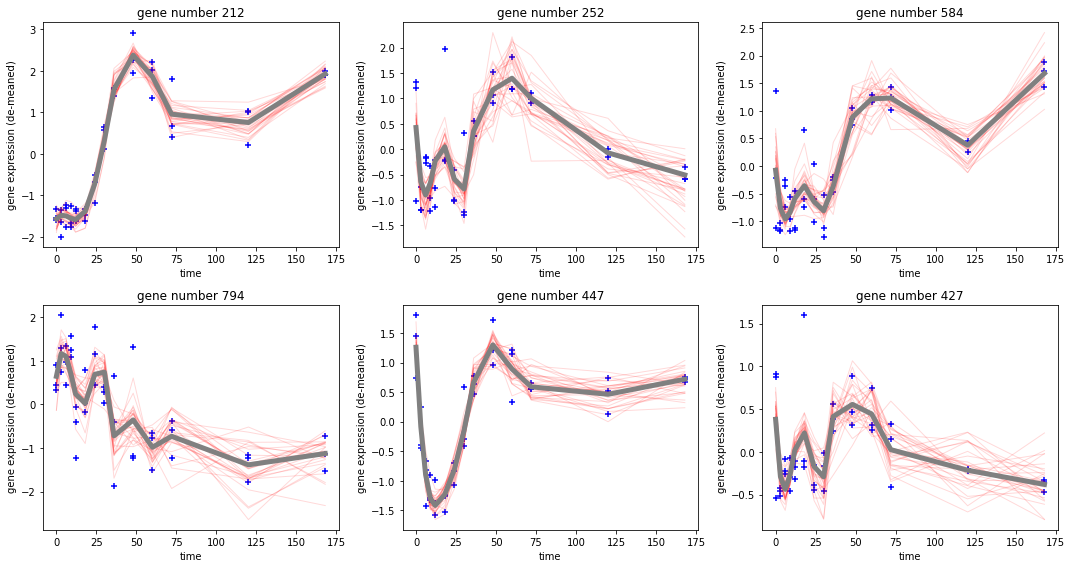

In [7]:
f, axarr = plt.subplots(2, 3, figsize=(15,8))

gene_indx = onp.random.choice(n_genes, 6)

for i in range(6):

    n = gene_indx[i]
    this_plot = axarr[int(np.floor(i / 3)), i % 3]
    
    regression_plotting_utils.plot_data(timepoints,
                                        genome_data[n],
                                        this_plot,
                                        demean = True)
    
    regression_plotting_utils.plot_prediction_line_and_sample(timepoints, 
                                                              regressors, 
                                                              beta[n],
                                                              beta_infos[n],
                                                              this_plot)
    
    this_plot.set_title('gene number {}'.format(n))
    this_plot.set_xlabel('time')
    this_plot.set_ylabel('gene expression (de-meaned)')


f.tight_layout()

# Prior parameters

In [8]:
prior_params_dict, prior_params_paragami = regression_mixture_lib.get_default_prior_params()

In [9]:
alpha0 = 6.0
prior_params_dict['dp_prior_alpha'] = alpha0

In [10]:
prior_params_dict

{'dp_prior_alpha': 6.0,
 'prior_centroid_mean': DeviceArray([0.], dtype=float64),
 'prior_centroid_info': DeviceArray([0.1], dtype=float64),
 'prior_shift_mean': DeviceArray([0.], dtype=float64),
 'prior_shift_info': DeviceArray([0.1], dtype=float64),
 'prior_data_info_shape': DeviceArray([10.], dtype=float64),
 'prior_data_info_scale': DeviceArray([0.1], dtype=float64)}

# VB parameters

In [11]:
k_approx = 40
vb_params_dict, vb_params_paragami = regression_mixture_lib.get_vb_params_paragami_object(reg_dim, k_approx)

In [12]:
print(vb_params_paragami)

OrderedDict:
	[stick_params] = OrderedDict:
	[stick_means] = NumericArrayPattern (39,) (lb=-inf, ub=inf)
	[stick_infos] = NumericArrayPattern (39,) (lb=0.0001, ub=inf)
	[centroids] = NumericArrayPattern (40, 10) (lb=-inf, ub=inf)
	[data_info] = NumericArrayPattern (1,) (lb=0.0, ub=inf)


### Gauss hermite 

In [13]:
# Gauss-Hermite points for integrating logitnormal stick-breaking prior
gh_deg = 8
gh_loc, gh_weights = hermgauss(gh_deg)

# convert to jax arrays
gh_loc, gh_weights = np.array(gh_loc), np.array(gh_weights)

# Optimize

In [14]:
vb_init_dict = reg_optim_lib.set_params_w_kmeans(genome_data, 
                                                    regressors,
                                                    deepcopy(vb_params_dict), 
                                                    vb_params_paragami, 
                                                    prior_params_dict,
                                                    gh_loc, gh_weights, 
                                                    seed = 3453)

running initial regressions ...
running k-means ... 
initializing sticks ...


In [15]:
vb_opt_dict, vb_opt, ez_opt, out, optim_time = \
    reg_optim_lib.optimize_regression_mixture(genome_data,
                                              regressors, 
                                              vb_init_dict,
                                              vb_params_paragami,
                                              prior_params_dict, 
                                              gh_loc, 
                                              gh_weights)
print(out.fun)

compiling objective and derivatives ... 
done. Compile time: 20.725sec
Running L-BFGS-B ...
L-BFGS-B time: 26.533sec
Running trust-ncg ... 
Newton time: 15.947sec
Optimization terminated successfully.
done. 
3852.334830310447


In [18]:
foo_dict, _, meta_data = paragami.load_folded('../fits/mice_genomics_fit_alpha6.0.npz')
foo = vb_params_paragami.flatten(foo_dict, free = True)
print(np.abs(vb_opt - foo).max())
print(meta_data['final_kl'] - out.fun)

4.728101618889369e-06
-4.674802767112851e-10


# Check out fit

In [19]:
def get_e_num_obs_per_cluster(vb_params_free): 
    
    vb_params_dict = vb_params_paragami.fold(vb_params_free, free = True)
    
    ez = reg_posterior_quantities.get_optimal_local_params_from_vb_dict(genome_data, regressors,
                                                   vb_params_dict,
                                                   prior_params_dict, 
                                                   gh_loc, gh_weights)[0]
    
    return ez.sum(0)

In [20]:
def get_mixture_weights(vb_params_free): 

    vb_params_dict = vb_params_paragami.fold(vb_params_free, free = True)
    
    return reg_posterior_quantities.get_e_mixture_weights_from_vb_dict(vb_params_dict, gh_loc, gh_weights)

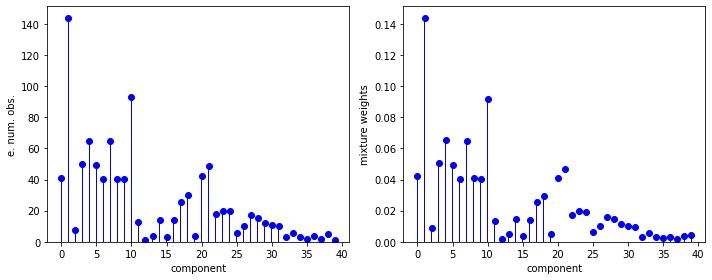

In [21]:
# plot mixture weights and allocations

e_num_obs_per_cluster = get_e_num_obs_per_cluster(vb_opt)
mixture_weights = get_mixture_weights(vb_opt)

fig, axarr = plt.subplots(1, 2, figsize = (10, 4))

result_loading_utils._plot_weights(e_num_obs_per_cluster, 
                                   axarr[0])

result_loading_utils._plot_weights(mixture_weights, 
                                   axarr[1])


axarr[0].set_ylabel('e. num. obs.')
axarr[1].set_ylabel('mixture weights')
    
fig.tight_layout()


### Plot top centroids

In [22]:
def plot_top_clusters(vb_params_dict, ez): 
    top_clusters_sorted = np.argsort(-e_num_obs_per_cluster)
    
    # centroids
    est_centroids = vb_params_dict['centroids']
    
    # shifts
    est_shifts = reg_posterior_quantities.get_optimal_local_params_from_vb_dict(genome_data,
                                                                            regressors,
                                                                            vb_params_dict,
                                                                            prior_params_dict, 
                                                                            gh_loc, gh_weights)[2]
    
    # average observations across replicates 
    # for plotting
    mean_operator = onp.zeros((genome_data.shape[1], n_timepoints))
    for i in range(n_timepoints): 
        mean_operator[3*i:((i+1)*3), i] = 1/3

    unique_timepoints = np.unique(timepoints)
    _y = np.dot(genome_data, mean_operator)
    
    
    ###############
    # PLOT
    ###############
    f, axarr = plt.subplots(2, 3, figsize=(15,8))

    for i in range(6):
        which_cluster = top_clusters_sorted[i]

        # genes in this cluster
        which_genes = np.argwhere(ez.argmax(1) == which_cluster).squeeze()

        this_plot = axarr[int(np.floor(i / 3)), i % 3]

        this_plot.set_title('cluster = {}; num. genes = {}'.format(which_cluster, len(which_genes)))
        this_plot.set_xlabel('time')
        this_plot.set_ylabel('gene expression (shifted)')

        # Plot genes in this cluster
        for n in which_genes: 
            this_plot.plot(unique_timepoints, _y[n] - est_shifts[n, which_cluster],
                           color = 'grey')

        # plot centroid
        regression_plotting_utils.plot_prediction_line(timepoints, 
                                                       regressors, 
                                                       est_centroids[which_cluster], 
                                                       ax = this_plot, 
                                                       linewidth = 5, 
                                                       color = 'green')


    f.tight_layout()


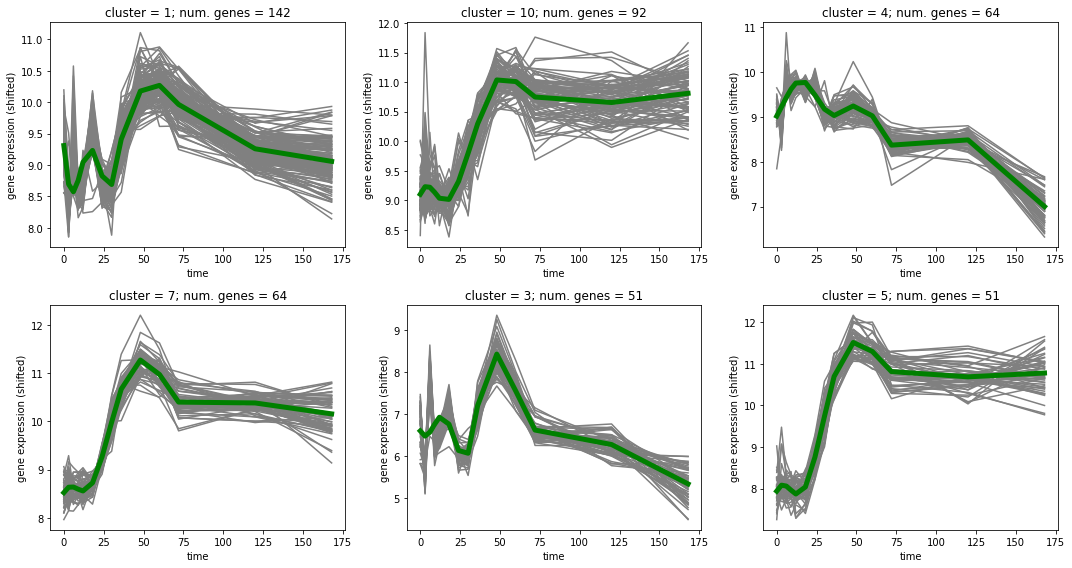

In [23]:
plot_top_clusters(vb_opt_dict, ez_opt)

### Plot a couple genes

In [24]:
# f, axarr = plt.subplots(2, 3, figsize=(15,8))

# gene_indx = onp.random.choice(n_genes, 6)

# for i in range(6):
#     n = gene_indx[i]
#     # membership of gene n
#     which_cluster = np.argmax(ez_opt[n])

    
#     this_plot = axarr[int(np.floor(i / 3)), i % 3] 
    
#     this_plot.set_ylabel('gene expression (shifted)')
#     this_plot.set_xlabel('index')
#     this_plot.set_title('gene number ' + str(n) + \
#                         '; cluster ' + str(which_cluster) + \
#                         '; prob z = {:.03f}'.format(ez_opt[n].max()))
    
    
#     # plot data
#     regression_plotting_utils.plot_data(timepoints,
#                                         genome_data[n] - est_shifts[n, which_cluster],
#                                         this_plot,
#                                         demean = False)
    
#     # plot prediction 
#     regression_plotting_utils.plot_prediction_line(timepoints, 
#                                                    regressors, 
#                                                    est_centroids[which_cluster], 
#                                                    ax = this_plot, 
#                                                    linewidth = 5, 
#                                                    color = 'green')
# f.tight_layout()


# Parametric sensitivity

In [25]:
use_free_alpha = True
hyper_param0 = prior_params_paragami['dp_prior_alpha'].flatten(prior_params_dict['dp_prior_alpha'],
                                                      free = use_free_alpha)

In [26]:
# set up objective as function of vb params and prior param 

def objective_fun(vb_params_dict, alpha): 
    
    _prior_params_dict = deepcopy(prior_params_dict)
    _prior_params_dict['dp_prior_alpha'] = alpha
    
    return regression_mixture_lib.get_kl(genome_data, regressors,
                                         vb_params_dict,
                                         _prior_params_dict,
                                         gh_loc,
                                         gh_weights).squeeze()


objective_fun_free = paragami.FlattenFunctionInput(
                                original_fun=objective_fun, 
                                patterns = [vb_params_paragami, prior_params_paragami['dp_prior_alpha']],
                                free = [True, use_free_alpha],
                                argnums = [0, 1])


In [27]:
vb_sens = HyperparameterSensitivityLinearApproximation(objective_fun_free,
                                                        vb_opt,
                                                        hyper_param0)

Compiling hessian solver ...
Hessian solver compile time: 22.9789sec

Compiling cross hessian...
Cross-hessian compile time: 0.502558sec

LR sensitivity time: 2.13186sec



# Fit for a range of alpha

In [28]:
alpha_list = np.arange(1, 15, dtype = float)

### Define and pre-compile gradients

So we don't have to recompile for every alpha ...

In [29]:
get_grad = jax.jit(jax.grad(objective_fun_free, argnums = 0))

def _get_hvp(x, alpha, v):
    return jax.jvp(jax.grad(objective_fun_free, argnums = 0), (x, alpha), (v, 0.))[1]

get_hvp = jax.jit(_get_hvp)


In [30]:
# compile ... 
_ = get_grad(vb_opt, hyper_param0).block_until_ready()
_ = get_hvp(vb_opt, hyper_param0, vb_opt).block_until_ready()

### Now refit

In [31]:
def refit_with_alpha(alpha, new_init_dict):
    # sets new alpha, returns new vb optimum
    
    hyper_param_pert = prior_params_paragami['dp_prior_alpha'].flatten(alpha, 
                                                                       free = use_free_alpha)
    
    vb_opt_pert = optimize_kl(lambda x : objective_fun_free(x, hyper_param_pert),
                             new_init_dict, 
                             vb_params_paragami, 
                             get_grad = lambda x : get_grad(x, hyper_param_pert),
                             get_hvp = lambda x, v: get_hvp(x, hyper_param_pert, v),
                             # only run newton steps
                             run_lbfgs = False,
                             run_newton = True)[1]                             
        
    return vb_opt_pert

In [32]:
print('alphas: ', alpha_list)

alphas:  [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]


In [33]:
refit_list = []

new_init_dict = deepcopy(vb_opt_dict)

for alpha in alpha_list: 
    print('\n################')
    print('re-optimzing with alpha = ', alpha)
    print('################')
    
    refit_list.append(refit_with_alpha(alpha, new_init_dict))



################
re-optimzing with alpha =  1.0
################
compiling objective and derivatives ... 
done. Compile time: 2.107sec
Running trust-ncg ... 
Newton time: 11.293sec
Optimization terminated successfully.
done. 

################
re-optimzing with alpha =  2.0
################
compiling objective and derivatives ... 
done. Compile time: 2.103sec
Running trust-ncg ... 
Newton time: 9.699sec
Optimization terminated successfully.
done. 

################
re-optimzing with alpha =  3.0
################
compiling objective and derivatives ... 
done. Compile time: 2.101sec
Running trust-ncg ... 
Newton time: 11.410sec
Optimization terminated successfully.
done. 

################
re-optimzing with alpha =  4.0
################
compiling objective and derivatives ... 
done. Compile time: 2.111sec
Running trust-ncg ... 
Newton time: 11.787sec
Optimization terminated successfully.
done. 

################
re-optimzing with alpha =  5.0
################
compiling objective and der

### Get linear response for each alpha

In [53]:
lr_list = []

for alpha in alpha_list: 

    hyper_param_pert = prior_params_paragami['dp_prior_alpha'].flatten(alpha, free = use_free_alpha)
    
    # get linear response
    lr_list.append(vb_sens.predict_opt_par_from_hyper_par(hyper_param_pert))

In [54]:
np.abs(vb_sens.dinput_dhyper).max()

DeviceArray(0.9185673, dtype=float64)

### Print results

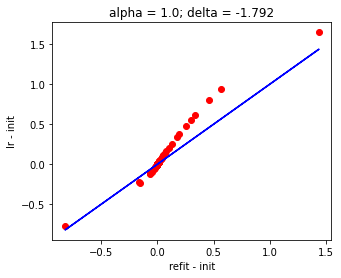

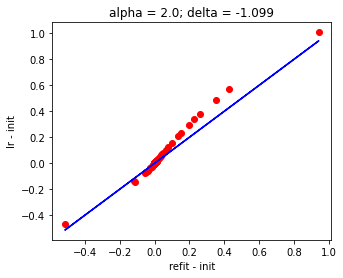

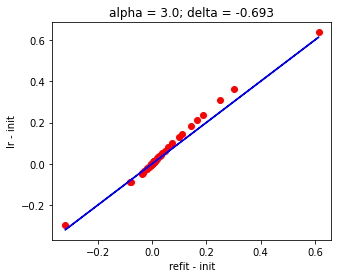

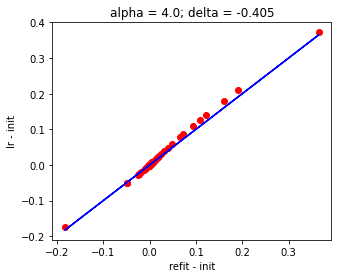

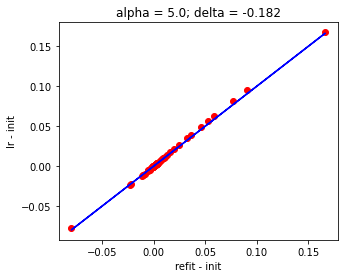

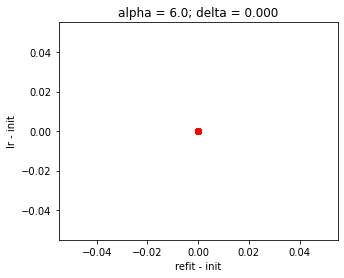

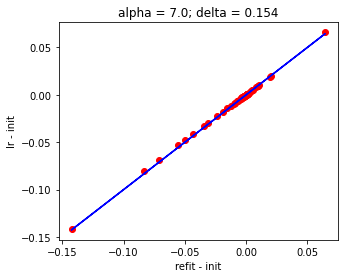

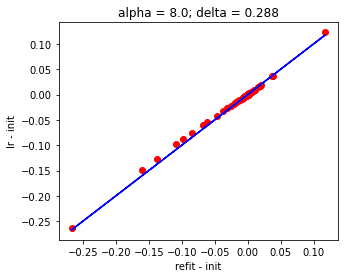

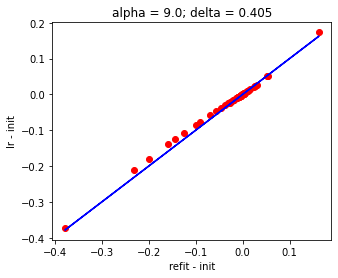

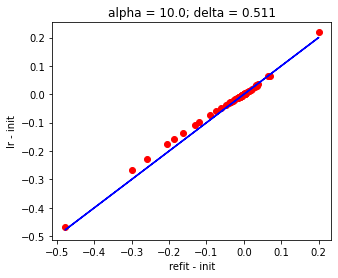

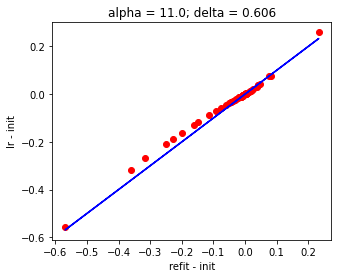

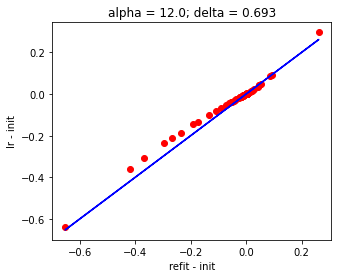

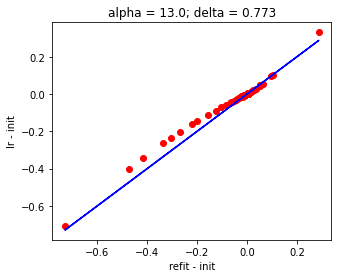

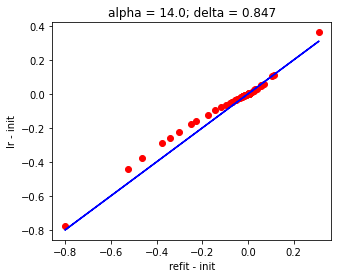

In [55]:
for i in range(len(alpha_list)): 
    fig, ax = plt.subplots(1, 1, figsize = (5, 4))

    result_loading_utils.print_diff_plot(refit_list[i], 
                    lr_list[i],
                    vb_opt,
                    ax, alpha = 1.)
    
    alpha = alpha_list[i]
    hyper_param_pert = prior_params_paragami['dp_prior_alpha'].flatten(alpha,
                                                              free = use_free_alpha)
    delta = hyper_param_pert - hyper_param0
    plt.title('alpha = ' + str(alpha) + '; delta = {:.03f}'.format(delta[0]))


# Results on number of clusters

In [56]:
import numpy as onp

In [57]:
prng_key = jax.random.PRNGKey(223)
threshold = 8

@jax.jit
def get_n_clusters_insample(vb_free):
    
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    return reg_posterior_quantities.get_e_num_clusters_from_vb_dict(genome_data, regressors,
                                                                        vb_params_dict,
                                                                        prior_params_dict,
                                                                        gh_loc, gh_weights,
                                                                        threshold = threshold,
                                                                        n_samples = 1000, 
                                                                        prng_key = prng_key)

@jax.jit
def get_n_clusters_pred(vb_free):
    
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    return reg_posterior_quantities.get_e_num_pred_clusters_from_vb_dict(vb_params_dict,
                                                               n_obs = genome_data.shape[0],
                                                               threshold = threshold,
                                                               prng_key = prng_key)


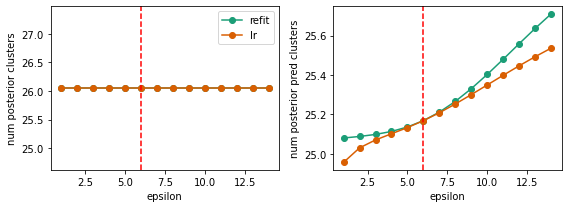

In [58]:
fig, axarr = plt.subplots(1, 2, figsize = (8, 3))

# in sample number of clusters
result_loading_utils.plot_post_stat_per_epsilon(get_n_clusters_insample, 
                                               refit_list,
                                               lr_list,
                                               alpha_list, 
                                               axarr[0])
axarr[0].set_ylabel('num posterior clusters')
axarr[0].legend()

# predictive number of clusters
result_loading_utils.plot_post_stat_per_epsilon(get_n_clusters_pred, 
                                               refit_list,
                                               lr_list,
                                               alpha_list, 
                                               axarr[1])

axarr[1].set_ylabel('num posterior pred clusters')

for i in range(2):
    axarr[i].axvline(alpha0, 
                     color = 'red', 
                     linestyle = '--')

fig.tight_layout()


# Other posterior quantities

In [59]:
import scipy.cluster.hierarchy as sch

# for better plotting, cluster the ez's
link = sch.linkage(ez_opt, method='average')
indx = sch.dendrogram(link, no_plot=True)["leaves"]

In [60]:
@jax.jit
def get_optimal_ez(vb_params_free): 
        
    vb_params_dict = vb_params_paragami.fold(vb_params_free, 
                                             free = True)
    
    ez  = reg_posterior_quantities.get_optimal_local_params_from_vb_dict(genome_data, regressors,
                                                                            vb_params_dict,
                                                                            prior_params_dict,
                                                                            gh_loc,
                                                                            gh_weights)[0][indx]
    return ez

In [61]:
@jax.jit
def get_coclustering(vb_params_free): 
    
    ez = get_optimal_ez(vb_params_free)
    
    return np.dot(ez, ez.transpose())


In [62]:
def get_coclust_mean_abs_diff(vb_params_free): 
    init_coclust = get_coclustering(vb_opt)
    pert_coclust = get_coclustering(vb_params_free) 
    
    return np.abs(pert_coclust - init_coclust).mean()


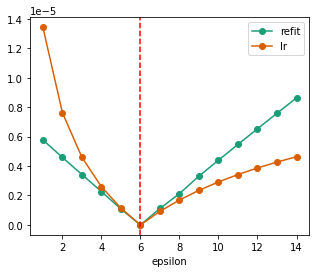

In [63]:
fig, ax = plt.subplots(1, 1, figsize = (5, 4))

result_loading_utils.plot_post_stat_per_epsilon(get_coclust_mean_abs_diff, 
                                               refit_list,
                                               lr_list,
                                               alpha_list, 
                                               ax)
ax.axvline(alpha0, 
           color = 'red', 
           linestyle = '--')

ax.legend()


In [69]:
# pick a particular alpha
alpha_pert = 11.0
alpha_indx = np.argwhere(alpha_list == alpha_pert).squeeze()

In [70]:
coclust_init = get_coclustering(vb_opt)
coclust_lr = get_coclustering(lr_list[alpha_indx])
coclust_refit = get_coclustering(refit_list[alpha_indx])

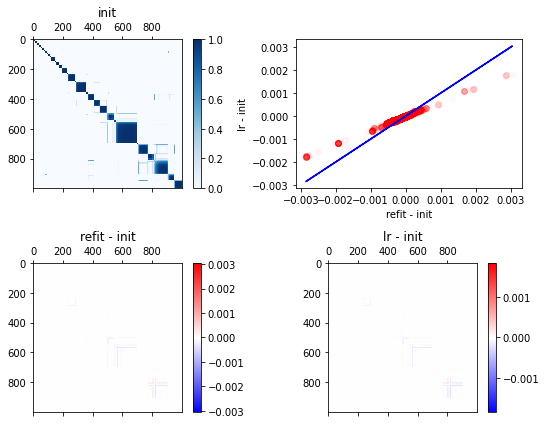

In [71]:
fig, axarr = plt.subplots(2, 2, figsize = (8, 6))

################
# initial co-clustering matrix
################
im0 = axarr[0, 0].matshow(coclust_init, 
                 cmap = plt.get_cmap('Blues'))
axarr[0, 0].set_title('init')
fig.colorbar(im0, ax = axarr[0, 0])

################
# differences
################
result_loading_utils.print_diff_plot(coclust_refit.flatten(), 
                                    coclust_lr.flatten(),
                                    coclust_init.flatten(), 
                                    axarr[0, 1], 
                                    alpha = 0.01)

result_loading_utils.plot_colormaps(coclust_refit,
                                   coclust_lr,
                                   coclust_init,
                                   fig,
                                   axarr[1], 
                                   plot_initial = False)
    
fig.tight_layout()


In [72]:
ez_init = get_optimal_ez(vb_opt)
ez_lr = get_optimal_ez(lr_list[alpha_indx])
ez_refit = get_optimal_ez(refit_list[alpha_indx])

In [78]:
# fig, axarr = plt.subplots(1, 1, figsize = (8, 6))

# result_loading_utils.print_diff_plot(ez_refit.flatten(),
#                                         ez_lr.flatten(),
#                                         ez_init.flatten(),
#                                         axarr, 
#                                         alpha = 1)


In [79]:
# fig, axarr = plt.subplots(1, 1, figsize = (8, 6))

# result_loading_utils.print_diff_plot(coclust_refit.flatten(),
#                                      coclust_lr.flatten(),
#                                      coclust_init.flatten(),
#                                      axarr, 
#                                      alpha = 1)


# Mixture weights

In [75]:
@jax.jit 
def get_mixture_weights(vb_free):
    
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    mixture_weights = reg_posterior_quantities.get_e_mixture_weights_from_vb_dict(vb_params_dict,
                                                                 gh_loc,
                                                                 gh_weights)
    
    return mixture_weights


In [76]:
def plot_e_num_obs_trace(): 
    
    # get arrays of mixture weights
    refit_array = result_loading_utils.get_post_stat_vec(get_mixture_weights, refit_list)
    lr_array = result_loading_utils.get_post_stat_vec(get_mixture_weights, lr_list)
    
        
    fig, ax = plt.subplots(2, 4, figsize = (16, 6), sharex = True) 
    
    for k in range(8): 
        x0 = k // 4
        x1 = k % 4
        ax[x0, x1].plot(alpha_list, 
                       refit_array[:, k], 
                       '-o',
                       color = result_loading_utils.refit_color, 
                       label = 'refit')
        
        ax[x0, x1].plot(alpha_list, 
                       lr_array[:, k], 
                       '-o',
                       color = result_loading_utils.lr_color, 
                       label = 'lr')
        
        ax[x0, x1].set_title('k = {}'.format(k))
        ax[x0, x1].axvline(alpha0, 
                           color = 'red', 
                           linestyle = '--')
        
        if k == 0: 
            ax[x0, x1].legend()
            
    for k in range(4): 
        ax[-1, k].set_xlabel('dp_prior_alpha')
        
    for k in range(2): 
        ax[k, 0].set_ylabel('E(# obs)')
    
    fig.tight_layout()


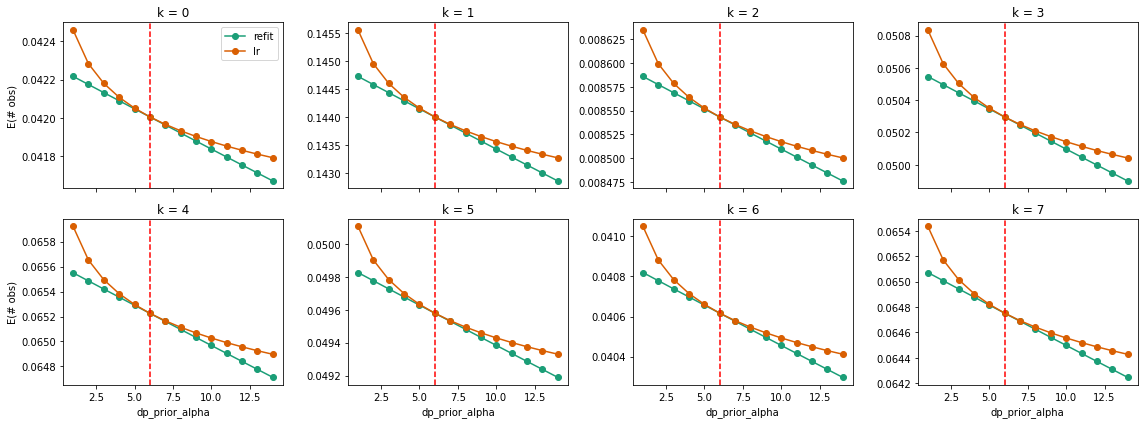

In [77]:
plot_e_num_obs_trace()